In [1]:
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors

In [2]:
#Load Dataset
Home_data = pd.read_csv('HomeC.csv')
nan_removed = pd.DataFrame.dropna(pd.DataFrame(Home_data))
nan_removed.value_counts()

C:\Users\M-SI\AppData\Local\Temp\ipykernel_4496\675098868.py:2: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  Home_data = pd.read_csv('HomeC.csv')


time        use [kW]  gen [kW]  House overall [kW]  Dishwasher [kW]  Furnace 1 [kW]  Furnace 2 [kW]  Home office [kW]  Fridge [kW]  Wine cellar [kW]  Garage door [kW]  Kitchen 12 [kW]  Kitchen 14 [kW]  Kitchen 38 [kW]  Barn [kW]  Well [kW]  Microwave [kW]  Living room [kW]  Solar [kW]  temperature  icon         humidity  visibility  summary     apparentTemperature  pressure  windSpeed  cloudCover  windBearing  precipIntensity  dewPoint  precipProbability
1451624400  0.932833  0.003483  0.932833            0.000033         0.020700        0.061917        0.442633          0.124150     0.006983          0.013083          0.000417         0.000150         0.000000         0.031350   0.001017   0.004067        0.001517          0.003483    36.14        clear-night  0.62      10.00       Clear       29.26                1016.91   9.18       cloudCover  282.0        0.0000           24.40     0.00                 1
1451960350  0.498450  0.054750  0.498450            0.000000         0.020100

In [4]:
# remove duplicates values for temperature, icon, humidity, visibility, summary, apparentTemperature, pressure, windSpeed, cloudCover, windBearing, precipIntensity, dewPoint, and precipProbability
duplicate_removed = nan_removed.drop_duplicates(subset=['temperature', 'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'], keep='first')
duplicate_removed['summary'].value_counts()

summary
Clear                       6549
Partly Cloudy               1083
Light Rain                   476
Drizzle                      180
Overcast                     105
Rain                          90
Mostly Cloudy                 79
Light Snow                    76
Flurries                      31
Breezy                        27
Snow                          20
Breezy and Partly Cloudy      18
Foggy                         17
Rain and Breezy                3
Heavy Snow                     3
Flurries and Breezy            2
Breezy and Mostly Cloudy       1
Dry                            1
Name: count, dtype: int64

In [5]:
# split the dataframe into 3 type of summary Clear, Cloudy, and other
clear = duplicate_removed[duplicate_removed['summary'] == 'Clear']
cloudy = duplicate_removed[duplicate_removed['summary'] == 'Overcast']
other = duplicate_removed[(duplicate_removed['summary'] != 'Clear') & (duplicate_removed['summary'] != 'Overcast')]
other['summary'] = 'Other'

C:\Users\M-SI\AppData\Local\Temp\ipykernel_4496\1364489543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other['summary'] = 'Other'


In [6]:
# combine the 3 dataframe into 1
frames = [clear, cloudy, other]
result = pd.concat(frames)

# change the summary into numerical value
result['summary'] = result['summary'].map({'Clear': 0, 'Overcast': -1, 'Other': 1})
result = result.reset_index(drop=True)

In [9]:
# select the best x values from result with y values is result['summary'] for SOM algorithm
X = result.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]]
y = result['summary']

In [10]:
data_x = X
data_y = y

In [11]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) # check the shapes

(7008, 14) (7008,) (1753, 14) (1753,)


In [12]:
# Helper functions
# Data Normalisation
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

In [13]:
# Euclidean distance
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

In [14]:
# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

In [15]:
# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [16]:
# hyperparameters
num_rows = 10
num_cols = 10
max_m_dsitance = 4
max_learning_rate = 0.5
max_steps = int(7.5*10e3)

In [17]:
#main function
train_x_norm = minmax_scaler(train_x) # normalisation

# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

In [18]:
# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
Iteration:  51000
Iteration:  52000
Iteration:  53000
Iteration:  54000
Iteration:  55000
Iteration:  56000
I

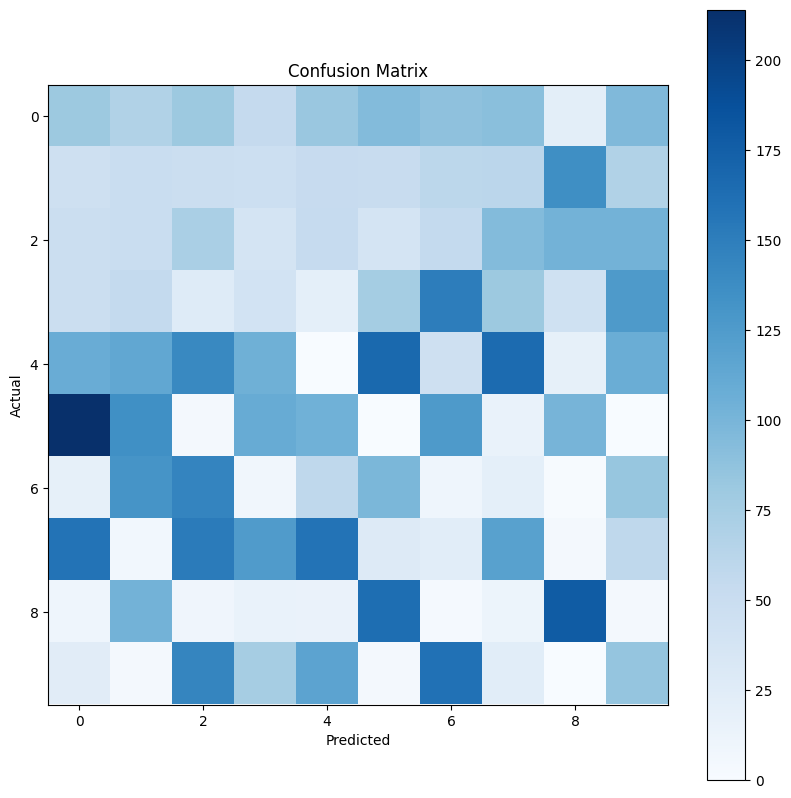

In [19]:
# plot the SOM in confusion matrix
# initialise the confusion matrix
confusion_matrix = np.zeros(shape=(num_rows, num_cols), dtype=np.int32)

# calculate the confusion matrix
for i in range(train_x_norm.shape[0]):
  winner = winning_neuron(train_x_norm, i, som, num_rows, num_cols)
  confusion_matrix[winner[0]][winner[1]] += 1

# plot the confusion matrix
plt.figure(figsize=(10,10))
plt.title("Confusion Matrix")
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
